# Google Earth Engine Panel Data Creation

## Initialize

In [1]:
!pip install geemap
# !pip install ee

In [2]:
#GEE specific
import ee
import geemap
import math

#plotting and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from time import time

In [3]:
# Postgres
import psycopg2

In [4]:
#!pip install pycodestyle
#!pip install pyflakes
#!pip install --upgrade pyflakes
#!pip install uszipcode

In [5]:
from uszipcode import SearchEngine

In [6]:
#Initialize Google Earth Engine
# ee.Authenticate() #just needed the 1st time
ee.Initialize()

In [7]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()

## Load Feature Collection - Shapefiles

In [8]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

In [9]:
la_county, sc_county

(<ee.featurecollection.FeatureCollection at 0x7f9fd75016a0>,
 <ee.featurecollection.FeatureCollection at 0x7f9fd7501880>)

In [10]:
#Income Data
la_county_income = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome-final")

## Load NAIP Imagery

In [11]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [12]:
def get_images(param_dict):
    source_image_collection = params['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

    
    

In [13]:
params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012,2014,2016,2018,2020],
        'counties': {'la_county': la_county, 'sc_county': sc_county}
         }

images = get_images(params)
images

{'2010_la_county': <ee.image.Image at 0x7f9fd7238430>,
 '2010_sc_county': <ee.image.Image at 0x7f9fd7238610>,
 '2012_la_county': <ee.image.Image at 0x7f9fd72387f0>,
 '2012_sc_county': <ee.image.Image at 0x7f9fd72389d0>,
 '2014_la_county': <ee.image.Image at 0x7f9fd7238bb0>,
 '2014_sc_county': <ee.image.Image at 0x7f9fd7238d90>,
 '2016_la_county': <ee.image.Image at 0x7f9fd7238f70>,
 '2016_sc_county': <ee.image.Image at 0x7f9fd723c190>,
 '2018_la_county': <ee.image.Image at 0x7f9fd723c370>,
 '2018_sc_county': <ee.image.Image at 0x7f9fd723c550>,
 '2020_la_county': <ee.image.Image at 0x7f9fd723c730>,
 '2020_sc_county': <ee.image.Image at 0x7f9fd723c910>}

In [14]:
#see what bands each image has:
images['2020_la_county'].bandNames().getInfo()

['R',
 'G',
 'B',
 'N',
 'R_Entropy',
 'R_Contrast',
 'R_Gearys',
 'G_Entropy',
 'G_Contrast',
 'G_Gearys',
 'B_Entropy',
 'B_Contrast',
 'B_Gearys',
 'N_Entropy',
 'N_Contrast',
 'N_Gearys',
 'NDVI']

In [15]:
#test to see if NAIP plot looks correct
Map.addLayer(images['2020_la_county'], {}, 'NAIP Test')

In [16]:
#test to see if NDVI plot looks correct (define a different location in santa clara county just for visibility)
source_image = images['2020_sc_county']

test_ndvi = source_image.normalizedDifference(['N', 'R']).rename('2020_NDVI')
test_ndvi

In [17]:
Map.addLayer(test_ndvi,{min : -1, max : 1, 'palette' : ['blue', 'white', 'green']}, 'NDVI Test')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Load Labeled Data

In [17]:
PROJECT_DIR = 'projects/california-lawn-detection/assets/'

water = ee.FeatureCollection(f"{PROJECT_DIR}water_torrance_0610")
vegetation_trees = ee.FeatureCollection(f"{PROJECT_DIR}trees_torrance")
vegetation_grass = ee.FeatureCollection(f"{PROJECT_DIR}grass_torrance").limit(400)
turf_1 = ee.FeatureCollection(f"{PROJECT_DIR}turf_torrance1")
turf_2 = ee.FeatureCollection(f"{PROJECT_DIR}turf_torrance2")
pv = ee.FeatureCollection(f"{PROJECT_DIR}pv_torrance")
impervious_1 = ee.FeatureCollection(f"{PROJECT_DIR}impervious_torrance1").limit(40)
impervious_2 = ee.FeatureCollection(f"{PROJECT_DIR}impervious_torrance2").limit(40)
soil = ee.FeatureCollection(f"{PROJECT_DIR}soil_torrance").limit(40)

turf = turf_1.merge(turf_2)
impervious= impervious_1.merge(impervious_2)

LABELED_SET = water.merge(vegetation_trees)\
                   .merge(vegetation_grass)\
                   .merge(turf)\
                   .merge(impervious)\
                   .merge(soil)
    
Map.addLayer(LABELED_SET, {}, 'labeled_set')

In [18]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Build Training Set

In [19]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'lacounty': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_lacounty']

In [20]:
# Overlay the points on the imagery to get training.
LABEL = 'landcover'
BANDS = ['R', 'G', 'B', 'N', 'NDVI',
         'R_Entropy',
         'R_Contrast',
         'R_Gearys',
         'G_Entropy',
         'G_Contrast',
         'G_Gearys',
         'B_Entropy',
         'B_Contrast',
         'B_Gearys',
         'N_Entropy',
         'N_Contrast', 
         'N_Gearys']

training_set = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': LABELED_SET,
  'properties': [LABEL],
  'scale': 1
})

In [21]:
set(BANDS)==set(TRAINING_IMAGE.bandNames().getInfo())

True

In [22]:
def training_area(image, training_class):
    
    area = image.reduceRegion(
           reducer = ee.Reducer.count(), 
           geometry = training_class.geometry(), 
           scale = 2, 
           maxPixels = 1e13
                )

    return(area.getInfo().get('B'))

In [23]:
def training_polygons(training_class):
    return(training_class.aggregate_count('label').getInfo())

In [24]:
# training information
training_classes = [water,
                         vegetation_trees,
                         vegetation_grass,
                         turf,
                         pv,
                         impervious,
                         soil]

class_names = ['water',
                         'vegetation_trees',
                         'vegetation_grass',
                         'turf',
                         'pv',
                         'impervious',
                         'soil']

try:
    for i in range(len(training_classes)):
        area_i = training_area(TRAINING_IMAGE, training_classes[i])
        polygons_i = training_polygons(training_classes[i])
        print(class_names[i],"pixels:", area_i ,", polygons", polygons_i)
except:
    print('ERROR. POSSIBLE MISMATCH IN CLASSES LIST AND NAMES LIST SIZES')



water pixels: 486 , polygons 199
vegetation_trees pixels: 17125 , polygons 772
vegetation_grass pixels: 23681 , polygons 400
turf pixels: 857 , polygons 215
pv pixels: 1723 , polygons 344
impervious pixels: 20360 , polygons 80
soil pixels: 8761 , polygons 40


## Separate Training Data into Train/Test

In [25]:
#Split Training and Test Set Randomly - there might be a better way to do this
print("Labeled Set Size in Pixels", training_set.aggregate_count('R').getInfo())
sample = training_set.randomColumn()
trainingSample = sample.filter('random <= 0.8')
validationSample = sample.filter('random > 0.8')
print("Training Set Size in Pixels", trainingSample.aggregate_count('R').getInfo())
print("Test Set Size in Pixels", validationSample.aggregate_count('R').getInfo())

Labeled Set Size in Pixels 284710
Training Set Size in Pixels 227871
Test Set Size in Pixels 56839


## Machine Learning Model

In [26]:
clf = ee.Classifier.smileRandomForest(numberOfTrees = 100).train(trainingSample, LABEL, BANDS)
clf

In [27]:
training_image_classified = TRAINING_IMAGE.select(BANDS).classify(clf)

In [28]:
legend_keys = ['water', 'vegetation_trees', 'vegetation_grass', 'turf','impervious','soil']
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

Map.addLayer(training_image_classified, {'min': 1, 'max': 7, 'palette': legend_colors}, 'Classification')

In [29]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Evaluation Metrics

### Train Accuracy

In [30]:
# train_accuracy = trainingSample.classify(clf).errorMatrix('landcover', 'classification')
# train_accuracy.getInfo()

In [31]:
# train_accuracy.accuracy().getInfo()

In [32]:
# np.array(train_accuracy.getInfo()).sum()

### Test Accuracy

In [33]:
# test_accuracy = validationSample.classify(clf).errorMatrix('landcover', 'classification')

In [34]:
# test_accuracy.accuracy().getInfo()

In [35]:
# np.array(test_accuracy.getInfo()).sum()

## Binary Classification and Area Calculation

In [36]:
def area_calculation(image, class_number, shape, pixel_scale = 20):
    
    areaImage = image.eq(class_number).multiply(ee.Image.pixelArea())
    
    area = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(), 
        geometry = shape.geometry(), 
        scale = pixel_scale, 
        maxPixels = 1e13)
    
    area_sq_m = area.getInfo().get('classification')
    
    area_sq_km = area_sq_m / 1e6
    
    return area_sq_km

### Create Panel Data

In [37]:
la_county_income_zipcode2 = ee.FeatureCollection("projects/california-lawn-detection/assets/income_zipcode2019")
la_county_income_zipcode = la_county_income_zipcode2.select(ee.List(['zipcode', '2019zipcod','shape_area']), ee.List(['ZipCode', 'Median_Income','Area_sqft']))

In [47]:
year_list = [2010,2012, 2014, 2016, 2018,2020]
zipcode_list = ['90802','90732','90744', '90011', '91331', '90650', '90201', '90250', '90044', '90805', '90280', '91342', '91744', '91335', '91706', '90706', '90003']

In [ ]:
#https://www.zillow.com/browse/homes/ca/los-angeles-county/

'90011', '91331', '90650', '90201', '90250', '90044', '90805', '90280', '91342', '91744', '91335', '91706', '90706', '90003', 
'93550', '90255', '93535', '91766', '90262', '91402', '93536', '90631', '90026', '90022', '91343', '90037', '90660', '90019',
'91770', '90640', '90042', '90001', '90731', '90066', '91732', '90004', '90006', '91702', '90813', '91406', '90744', '91605',
'91405', '91304', '91801', '91745', '90723', '93551', '90018', '90063', '90745', '90221', '90002', '90034', '91344', '90047',
'90220', '90046', '91767', '90703', '90023', '90065', '90638', '90057', '91789', '90032', '91306', '90033', '90025', '91352',
'91790', '90027', '91733', '90247', '90016', '90007', '90059', '90043', '90024', '91765', '91367', '90503', '90241', '91748',
'92821', '90242', '90604', '90806', '91311', '91355', '90275', '91606', '91016', '90045', '90501', '93534', '91401', '90815',
'90605', '90804', '90278', '90810', '90808', '90301', '91776', '90031', '90020', '91325', '91387', '90505', '90036', '90802',
'93552', '91350', '91321', '91601', '91001', '91711', '91104', '91340', '90012', '90049', '90062', '90266', '91326', '90260',
'90029', '91780', '90277', '91006', '91750', '91768', '91722', '91007', '91206', '90504', '91754', '91107', '90606', '90222',
'91773', '91423', '91791', '90008', '90601', '90005', '91324', '90807', '90230', '91303', '91214', '91604', '91731', '90712',
'91505', '91607', '90028', '90803', '91356', '91792', '91316', '90061', '91746', '91351', '91803', '90039', '90302', '90041',
'90710', '90713', '91724', '91741', '90035', '90405', '90017', '91301', '90038', '91103', '90064',
'90249',
'91740',
'91364',
'90291',
'91755',
'90304',
'91384',
'91010',
'90270',
'90274',
'91042',
'91030',
'91354',
'91302',
'91307',
'90240',
'91411',
'91403',
'91504',
'91775',
'90746',
'90303',
'90015',
'90292',
'91106',
'90403',
'91390',
'91201',
'90602',
'90404',
'90732',
'91011',
'90272',
'91202',
'91040',
'90265',
'90068',
'90069',
'90717',
'91501',
'90048',
'91101',
'90210',
'91602',
'90603',
'90254',
'90715',
'90670',
# '90502'
# '91204'
# '91203'
# '91506'
# '91723'
# '91361'
# '90701'
# '90245'
# '90232'
# '91208'
# '90248'
# '91436'
# '91105'
# '90716'
# '91381'
# '93543'
# '90305'
# '91108'
# '90212'
# '90040'
# '90293'
# '91502'
# '90755'
# '90402'
# '91207'
# '90013'
# '90010'
# '91024'
# '90056'
# '90211'
# '90077'
# '90094'
# '90290'
# '90401'
# '91020'
# '90095'
# '90014'
# '93591'
# '93510'
# '90058'
# '90021'
# '90704'
# '90089'
# '93532'
# '93553'
# '90067'
# '93544'
# '90071'
# '92397'
# '93243'
# '91210'
# '90639'
# '91008'
# '91371'
# '91759'
# '91129'
# '90506'
# '90840'
# '91608'
# '90831'
# '93563'
# '90822'
# '90073'
# '91188'
# '90090'
# '91749'
# '91756'
# '91769'
# '91771'
# '91772'
# '91778'
# '91788'
# '91795'
# '91793'
# '91797'
# '91799'
# '91802'
# '91841'
# '91804'
# '91899'
# '91896'
# '92248'
# '93539'
# '93584'
# '93590'
# '93586'
# '93599'
# '90009'
# '90030'
# '90050'
# '90052'
# '90051'
# '90054'
# '90053'
# '90055'
# '90060'
# '90070'
# '90072'
# '90074'
# '90076'
# '90075'
# '90078'
# '90080'
# '90079'
# '90082'
# '90081'
# '90084'
# '90083'
# '90087'
# '90086'
# '90088'
# '90093'
# '90091'
# '90097'
# '90096'
# '90101'
# '90099'
# '90103'
# '90102'
# '90185'
# '90174'
# '90189'
# '90209'
# '90202'
# '90213'
# '90223'
# '90224'
# '90231'
# '90239'
# '90233'
# '90251'
# '90261'
# '90264'
# '90263'
# '90267'
# '90295'
# '90294'
# '90296'
# '90307'
# '90306'
# '90309'
# '90308'
# '90311'
# '90310'
# '90313'
# '90312'
# '90398'
# '90397'
# '90406'
# '90408'
# '90407'
# '90410'
# '90409'
# '90411'
# '90507'
# '90509'
# '90508'
# '90510'
# '90607'
# '90609'
# '90608'
# '90612'
# '90610'
# '90637'
# '90652'
# '90651'
# '90659'
# '90662'
# '90661'
# '90665'
# '90671'
# '90702'
# '90707'
# '90711'
# '90714'
# '90733'
# '90734'
# '90747'
# '90749'
# '90748'
# '90801'
# '90809'
# '90833'
# '90832'
# '90835'
# '90834'
# '90842'
# '90845'
# '90844'
# '90847'
# '90846'
# '90853'
# '90848'
# '90895'
# '90888'
# '90899'
# '91003'
# '91009'
# '91012'
# '91017'
# '91023'
# '91021'
# '91025'
# '91031'
# '91041'
# '91043'
# '91066'
# '91046'
# '91077'
# '91102'
# '91109'
# '91114'
# '91110'
# '91116'
# '91115'
# '91118'
# '91117'
# '91123'
# '91121'
# '91125'
# '91124'
# '91126'
# '91175'
# '91131'
# '91184'
# '91182'
# '91186'
# '91185'
# '91187'
# '91191'
# '91189'
# '91209'
# '91221'
# '91224'
# '91222'
# '91226'
# '91225'
# '91305'
# '91308'
# '91310'
# '91309'
# '91312'
# '91313'
# '91322'
# '91327'
# '91329'
# '91328'
# '91330'
# '91334'
# '91333'
# '91337'
# '91341'
# '91346'
# '91353'
# '91357'
# '91365'
# '91372'
# '91376'
# '91380'
# '91383'
# '91382'
# '91385'
# '91386'
# '91388'
# '91393'
# '91392'
# '91395'
# '91394'
# '91399'
# '91396'

In [48]:
test_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : year_list,
        'counties': {'lacounty': la_county}
         }

inference_images = get_images(test_image_params)
inference_images

{'2010_lacounty': <ee.image.Image at 0x7faa8b607af0>,
 '2012_lacounty': <ee.image.Image at 0x7faa8b607cd0>,
 '2014_lacounty': <ee.image.Image at 0x7faa8b607eb0>,
 '2016_lacounty': <ee.image.Image at 0x7faa8b60b0d0>,
 '2018_lacounty': <ee.image.Image at 0x7faa8b60b2b0>,
 '2020_lacounty': <ee.image.Image at 0x7faa8b60b490>}

In [49]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "34.201.28.96",
    port = "5432",
    database = "postgres"
)
cursor = connection.cursor()

In [50]:
#cursor = connection.cursor()

In [51]:

sr = SearchEngine()

def insert_panel_zipcode(year, zipcode, water_area, tree_area, grass_area, turf_area, 
                         impervious_area, soil_area, total_area):

    connection.rollback()
    
    z = sr.by_zipcode(zipcode)
    city = z.major_city
    state = z.state_abbr
    print("state", state)
    county = z.county
    median_income = z.median_household_income
    
    panel_zipcode_dict ={ 'item' : (state, 
                                    county, 
                                    zipcode, 
                                    city, 
                                    year, 
                                    round(total_area, 8),
                                    round(water_area, 8),
                                    round(grass_area, 8), 
                                    round(tree_area, 8),
                                    0.0, 
                                    round(impervious_area, 8), 
                                    round(soil_area, 8), 
                                    round(turf_area,  8),
                                    median_income, 
                                    0.0),
    }

    
    print(panel_zipcode_dict)
    
    columns= panel_zipcode_dict.keys()
    
    for i in panel_zipcode_dict.values():
        
        query = '''

        INSERT INTO panel_zipcode (state, 
                                    county, 
                                    zipcode, 
                                    city_neighborhood, 
                                    year, 
                                    polygon_area, 
                                    water_area, 
                                    lawn_area, 
                                    tree_area, 
                                    pv_area, 
                                    impervious_area, 
                                    soil_area, 
                                    turf_area, 
                                    median_income, 
                                    water_usage)
            VALUES {}; '''.format(i)

    cursor.execute(query)

    connection.commit()

In [52]:

#connection.close()

In [53]:
keys = {'year','polygon','water_area','vegetation_trees_area', 'vegetation_grass_area', 'turf_area', 'impervious_area','soil_area', 'total_area'}
dictionary = {}
for i in keys:
    dictionary[i] = []

for i in zipcode_list:
    for j in list(inference_images.items()):
        im = j[1]
        imagery = im.select(BANDS).classify(clf)
        name = j[0]
        
        start = time()
        polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', i))

        dictionary['year'].append(j[0][:4]) 
        year = j[0][:4]
        
        dictionary['polygon'].append(i)
        zipcode = i
        
        water_area = area_calculation(imagery, 1, polygon, 20)
        dictionary['water_area'].append(water_area)
        
        tree_area = area_calculation(imagery, 2, polygon, 20)
        dictionary['vegetation_trees_area'].append(tree_area)

        grass_area = area_calculation(imagery, 3, polygon, 20)
        dictionary['vegetation_grass_area'].append(grass_area)

        turf_area = area_calculation(imagery, 4, polygon, 20)
        dictionary['turf_area'].append(turf_area)

        impervious_area = area_calculation(imagery, 6, polygon, 20)
        dictionary['impervious_area'].append(impervious_area)

        soil_area = area_calculation(imagery, 7, polygon, 20)
        dictionary['soil_area'].append(soil_area)

        total_area = water_area + tree_area + grass_area + turf_area + impervious_area + soil_area
        dictionary['total_area'].append(total_area)
        end = time()
        print(f'Zip Code: {i}, Year: {j[0][:4]} ::: completed in {end-start} seconds.')
        insert_panel_zipcode(year, zipcode, water_area, tree_area, grass_area, turf_area, impervious_area, soil_area, total_area)
        
        
              
              

Zip Code: 90802, Year: 2010 ::: completed in 10.36501669883728 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90802', 'Long Beach', '2010', 14.7566175, 0.00795953, 5.41678755, 0.67020571, 0.0, 5.24161035, 3.40706392, 0.01299043, 43404, 0.0)}
Zip Code: 90802, Year: 2012 ::: completed in 9.077438592910767 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90802', 'Long Beach', '2012', 14.7566175, 4.84506645, 0.22941502, 0.00099503, 0.0, 9.6791511, 0.0, 0.0019899, 43404, 0.0)}
Zip Code: 90802, Year: 2014 ::: completed in 10.121249675750732 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90802', 'Long Beach', '2014', 14.7566175, 0.24998898, 0.47664703, 0.07694881, 0.0, 13.79175634, 0.00398042, 0.15729593, 43404, 0.0)}
Zip Code: 90802, Year: 2016 ::: completed in 9.22202181816101 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90802', 'Long Beach', '2016', 14.7566175, 0.0, 0.39495213, 0.31565717, 0.0, 13.56388533, 0.25756882, 0.22455406, 43404, 0.0)}
Zip Co

Zip Code: 90650, Year: 2016 ::: completed in 63.25748801231384 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90650', 'Norwalk', '2016', 25.2272037, 0.00066243, 1.60844698, 0.65934809, 0.0, 17.10087352, 5.85423019, 0.0036425, 60770, 0.0)}
Zip Code: 90650, Year: 2018 ::: completed in 57.299495458602905 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90650', 'Norwalk', '2018', 25.2272037, 0.02880823, 2.5561719, 0.54550256, 0.0, 21.50291382, 0.5129351, 0.0808721, 60770, 0.0)}
Zip Code: 90650, Year: 2020 ::: completed in 61.924864530563354 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90650', 'Norwalk', '2020', 25.2272037, 0.0, 1.52166666, 3.89424662, 0.0, 10.45064853, 9.11072418, 0.24991772, 60770, 0.0)}
Zip Code: 90201, Year: 2010 ::: completed in 61.28501224517822 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90201', 'Bell Gardens', '2010', 15.71865151, 0.00132365, 6.34640179, 2.25259677, 0.0, 2.05862335, 5.05639689, 0.00330906, 37267, 0.0)}
Zip 

Zip Code: 91342, Year: 2010 ::: completed in 279.24290323257446 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91342', 'Sylmar', '2010', 169.40073355, 0.01685248, 57.81177708, 23.66824048, 0.0, 24.43788523, 63.41523736, 0.05074093, 59329, 0.0)}
Zip Code: 91342, Year: 2012 ::: completed in 302.26264548301697 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91342', 'Sylmar', '2012', 169.40073355, 3.94862146, 33.79795916, 78.26083826, 0.0, 48.98979449, 2.6962692, 1.70725098, 59329, 0.0)}
Zip Code: 91342, Year: 2014 ::: completed in 341.25947284698486 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91342', 'Sylmar', '2014', 169.40073355, 0.50754926, 26.20590249, 72.17759711, 0.0, 56.75496505, 10.81259085, 2.94212879, 59329, 0.0)}
Zip Code: 91342, Year: 2016 ::: completed in 279.96370363235474 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91342', 'Sylmar', '2016', 169.40073355, 0.00263702, 4.38677409, 52.61818255, 0.0, 57.34131765, 53.73184189, 1.319980

Zip Code: 90003, Year: 2016 ::: completed in 9.68558406829834 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90003', 'Los Angeles', '2016', 9.53676173, 0.00033094, 0.10800637, 0.32975947, 0.0, 8.3858156, 0.67774913, 0.03510022, 29686, 0.0)}
Zip Code: 90003, Year: 2018 ::: completed in 9.096897602081299 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90003', 'Los Angeles', '2018', 9.53676173, 0.01687078, 0.41634207, 0.12395131, 0.0, 8.91309708, 0.01836711, 0.04813338, 29686, 0.0)}
Zip Code: 90003, Year: 2020 ::: completed in 8.625894546508789 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90003', 'Los Angeles', '2020', 9.53676173, 0.0, 0.29515492, 0.86956633, 0.0, 5.91632465, 2.31277057, 0.14294525, 29686, 0.0)}


In [ ]:
#extract just necessary columns from dictionary dataframe
df = pd.DataFrame(dictionary)[['polygon','soil_area','vegetation_grass_area','water_area','vegetation_trees_area','impervious_area','turf_area']]
df

### Plot Results

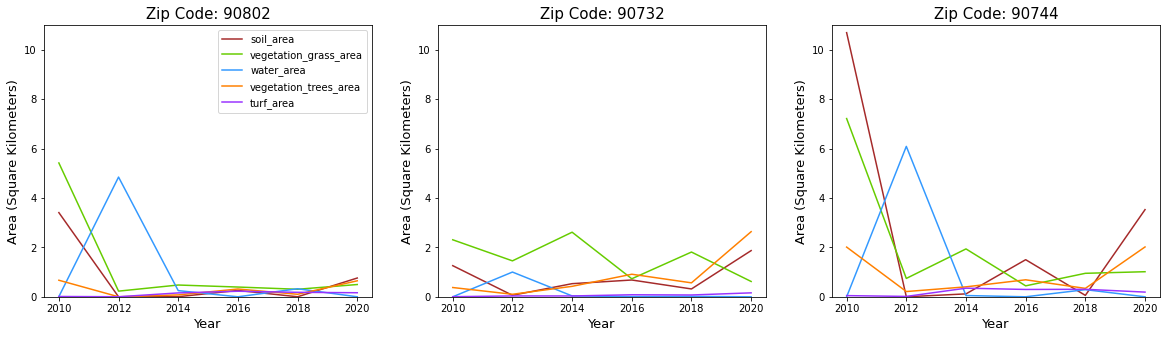

In [42]:
years= [2010, 2012, 2014, 2016, 2018, 2020]
zips = df.polygon.unique()
fig, ax = plt.subplots(1,3, figsize = (20,5))

labels = [ 'soil_area',
 'vegetation_grass_area',
 'water_area',
 'vegetation_trees_area',
 'turf_area']

colors = ['brown','#66CC00','#3399FF','#FF8000','#9933FF']


for i in range(3):
    for j in range(len(labels)):
        if j == 'polygon':
            continue
        else:
            d = df[df.polygon == zips[i]]
            ax[i].plot(years, d[labels[j]], color = colors[j], label = labels[j])
    ax[i].set_title(f'Zip Code: {zips[i]}', size = 15)
    ax[i].set_xlabel('Year', size = 13)
    ax[i].set_ylabel('Area (Square Kilometers)', size = 13)
    ax[i].set_ylim(0,11)
    ax[0].legend()
    
# plt.savefig(fname = 'test.png', dpi = 200)